<a href="https://colab.research.google.com/github/Eximmius/Thumbs-Classifier/blob/master/Thumbs_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fonte:
https://medium.com/analytics-vidhya/how-to-do-image-classification-on-custom-dataset-using-tensorflow-52309666498e


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_root = ('/content/drive/My Drive/thumbs_dataset')

In [ ]:
import tensorflow as tf

IMAGE_SHAPE = (224, 224) # (height, width) in no. of pixels
TRAINING_DATA_DIR = str(data_root)
datagen_kwargs = dict(rescale=1./255, validation_split=.20)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset='validation',
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset='training',
shuffle=True,
target_size=IMAGE_SHAPE)

Found 22 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 2))

In [ ]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

thumbs_down
thumbs_up

In [ ]:
import tensorflow_hub as hub
model = tf.keras.Sequential([
 hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 
 output_shape=[1280],
 trainable=False),
 tf.keras.layers.Dropout(0.4),
 tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   multiple                  2257984   
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-3)
model.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['acc'])

In [ ]:
import numpy as np
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
 train_generator, 
 epochs=25,
 verbose=1,
 steps_per_epoch=steps_per_epoch,
 validation_data=valid_generator,
 validation_steps=val_steps_per_epoch).history

Epoch 1/25
3/3 [==============================] - 56s 19s/step - loss: 1.2845 - acc: 0.4556 - val_loss: 0.7112 - val_acc: 0.5455
Epoch 2/25
3/3 [==============================] - 9s 3s/step - loss: 0.9906 - acc: 0.4444 - val_loss: 0.7391 - val_acc: 0.5455
Epoch 3/25
3/3 [==============================] - 10s 3s/step - loss: 0.6415 - acc: 0.6889 - val_loss: 0.6202 - val_acc: 0.5909
Epoch 4/25
3/3 [==============================] - 10s 3s/step - loss: 0.6198 - acc: 0.7111 - val_loss: 0.4856 - val_acc: 0.7727
Epoch 5/25
3/3 [==============================] - 9s 3s/step - loss: 0.4674 - acc: 0.7667 - val_loss: 0.4064 - val_acc: 0.8636
Epoch 6/25
3/3 [==============================] - 10s 3s/step - loss: 0.3930 - acc: 0.8556 - val_loss: 0.3777 - val_acc: 0.8636
Epoch 7/25
3/3 [==============================] - 10s 3s/step - loss: 0.3082 - acc: 0.8667 - val_loss: 0.4071 - val_acc: 0.7727
Epoch 8/25
3/3 [==============================] - 9s 3s/step - loss: 0.2575 - acc: 0.8889 - val_loss: 0.4

In [ ]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))

1/1 [==============================] - 0s 2ms/step - loss: 0.2089 - acc: 0.9091
Final loss: 0.21
Final accuracy: 90.91%


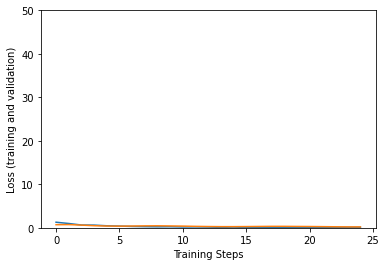

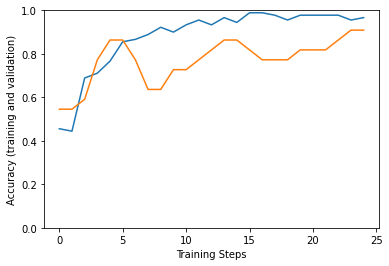

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.ylabel('Loss (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0,50])
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.figure()
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0,1])
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

tf_model_predictions = model.predict(val_image_batch)
print('Prediction results shape:', tf_model_predictions.shape)

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
print(predicted_labels)

Validation batch shape: (22, 224, 224, 3)
['Thumbs_Down' 'Thumbs_Up']
Prediction results shape: (22, 2)
['Thumbs_Down' 'Thumbs_Up' 'Thumbs_Up' 'Thumbs_Down' 'Thumbs_Down'
 'Thumbs_Up' 'Thumbs_Up' 'Thumbs_Up' 'Thumbs_Up' 'Thumbs_Down' 'Thumbs_Up'
 'Thumbs_Down' 'Thumbs_Down' 'Thumbs_Down' 'Thumbs_Up' 'Thumbs_Down'
 'Thumbs_Up' 'Thumbs_Down' 'Thumbs_Up' 'Thumbs_Down' 'Thumbs_Down'
 'Thumbs_Down']


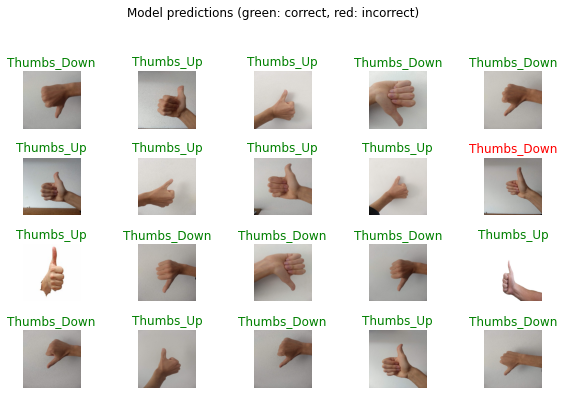

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(predicted_labels)-2)):
 plt.subplot(6,5,n+1)
 plt.imshow(val_image_batch[n])
 color = 'green' if predicted_ids[n] == true_label_ids[n] else 'red'
 plt.title(predicted_labels[n].title(), color=color)
 plt.axis('off')
_ = plt.suptitle('Model predictions (green: correct, red: incorrect)')